In [3]:
!wget "https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv"

--2025-05-01 01:53:07--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv [following]
--2025-05-01 01:53:08--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1032085 (1008K) [text/plain]
Saving to: ‘clientes_segmentos (1).csv’

clientes_segmento

P1. Distribución multivariada

a) Representa la relación edad vs. ingresos vs. plataforma en un gráfico de dispersión
3–D o de burbujas.

b) Identifica y comenta dos insights accionables.

In [41]:
import pandas as pd
import plotly.express as px
import os


cwd = os.getcwd()

file_path = os.path.join(cwd, 'clientes_segmentos (1).csv')


df = pd.read_csv(file_path)


df['edad'] = pd.to_numeric(df['edad'], errors='coerce')
df['ingresos'] = pd.to_numeric(df['ingresos'], errors='coerce')


df_grafico = df.dropna(subset=['edad', 'ingresos', 'plataforma'])


colores_plataforma = {
    'Instagram': 'blue',
    'TikTok': 'yellow',
    'Facebook': 'purple'

}

fig = px.scatter_3d(df_grafico, x='edad', y='ingresos', z='plataforma',
                    color='plataforma',
                    color_discrete_map=colores_plataforma,
                    title=' Edad / Ingresos / Plataforma')
fig.show()

P2. RFM preliminar

• Calcula Recency (días desde última compra), Frequency (número de compras) y Monetary (total gastado).

• Muestra una matriz de correlaciones (heatmap) de R, F, M + recomendaciones.

• ¿Qué combinación de variables captura mejor el valor futuro del cliente? Justifica.



Matriz de correlacion RFM:
             Recency  Frequency  Monetary
Recency    1.000000  -0.003188 -0.003745
Frequency -0.003188   1.000000  0.633622
Monetary  -0.003745   0.633622  1.000000


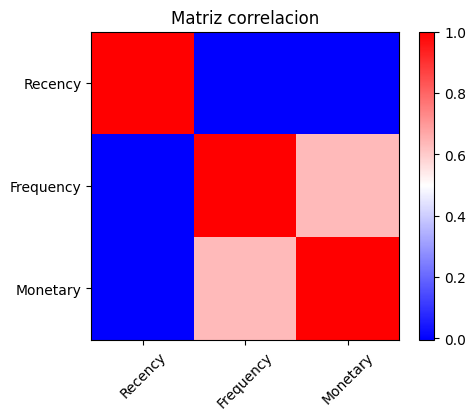

In [40]:
from datetime import datetime
import matplotlib.pyplot as plt

Hoy = datetime(2025, 4, 30)
df['Recency'] = (Hoy - pd.to_datetime(df['fecha_ultima_compra'])).dt.days
df['Frequency'] = df['compras']
df['Monetary'] = df['total_gastado']
rfm = df[['Recency', 'Frequency', 'Monetary']]
correlacion = rfm.corr()
print("\nMatriz de correlacion RFM:\n", correlacion)
plt.figure(figsize=(5, 4))
plt.imshow(correlacion, cmap='bwr', interpolation='nearest')
plt.xticks(range(len(correlacion.columns)), correlacion.columns, rotation=45)
plt.yticks(range(len(correlacion.index)), correlacion.index)
plt.colorbar()
plt.title('Matriz correlacion')
plt.show()

Fase 2 – Métricas de Negocio (CAC, LTV, ROI)

P3. CAC detallado
Calcula el CAC ponderado por plataforma considerando el campo costo_adquisicion y el
porcentaje de clientes activos por plataforma. Presenta los resultados en un gráfico de
barras apiladas.

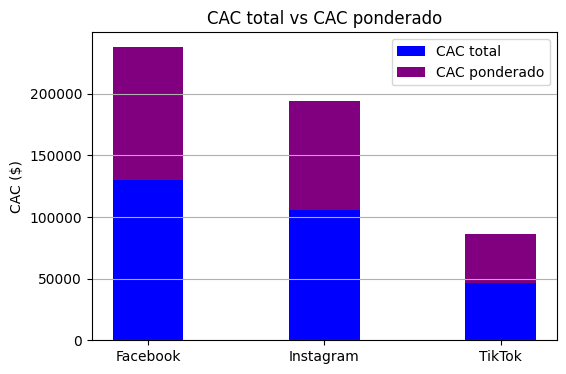

In [39]:
import numpy as np
hoy = datetime(2025, 4, 30)

df['fecha_ultima_compra'] = pd.to_datetime(df['fecha_ultima_compra'])
df['dias_desde_ultima'] = (hoy - df['fecha_ultima_compra']).dt.days
df['activo'] = df['dias_desde_ultima'] <= 180
resumen = df.groupby('plataforma').agg(
    total_clientes=('id_cliente', 'count'),
    clientes_activos=('activo', 'sum'),
    cac_total=('costo_adquisicion', 'sum')
).reset_index()
resumen['porc_activos'] = resumen['clientes_activos'] / resumen['total_clientes']
resumen['CAC_ponderado'] = resumen['cac_total'] * resumen['porc_activos']
plt.figure(figsize=(6, 4))
bar_width = 0.4
x = np.arange(len(resumen))
plt.bar(x, resumen['cac_total'], width=bar_width, label='CAC total', color='blue')
plt.bar(x, resumen['CAC_ponderado'], width=bar_width, label='CAC ponderado', color='purple', bottom=resumen['cac_total'])

plt.xticks(x, resumen['plataforma'])
plt.ylabel('CAC ($)')
plt.title('CAC total vs CAC ponderado')
plt.legend()
plt.grid(axis='y')
plt.show()

P4. LTV proyectado

Estima el LTV a 12 meses usando:

LT V = promedio_ticket × frecuencia_mensual × 12 × tasa_de_retención
con la tasa de retención siguiente:
Intervalo dias_desde_ultima Retención
≤ 90 80 %
91–180 60 %
> 180 30 %
Grafica la distribución (histograma + KDE) y reporta los clientes en el percentil 90 de LTV.

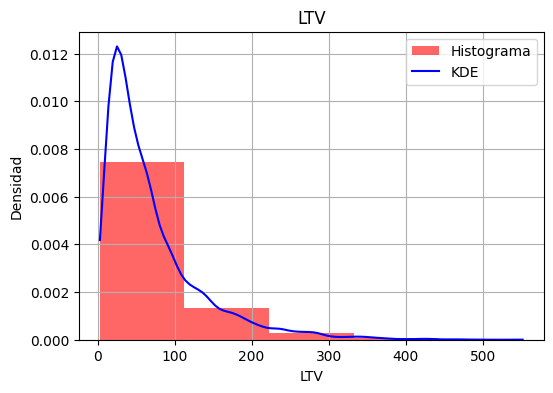

In [37]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

df['fecha_ultima_compra'] = pd.to_datetime(df['fecha_ultima_compra'])

df['promedio_ticket'] = df['total_gastado'] / df['compras']
df['frecuencia_mensual'] = df['compras'] / 12

def retencion(dias):
    if dias <= 90:
        return 0.80
    elif dias <= 180:
        return 0.60
    else:
        return 0.30

hoy = pd.to_datetime("2025-04-30")
df['dias_desde_ultima'] = (hoy - df['fecha_ultima_compra']).dt.days
df['tasa_retencion'] = df['dias_desde_ultima'].apply(retencion)

df['LTV'] = df['promedio_ticket'] * df['frecuencia_mensual'] * 12 * df['tasa_retencion']


plt.figure(figsize=(6, 4))
counts, bins, patches = plt.hist(df['LTV'], bins=5, density=True, alpha=0.6, color='red', label='Histograma')

kde = gaussian_kde(df['LTV'])
x_vals = np.linspace(min(df['LTV']), max(df['LTV']), 100)
plt.plot(x_vals, kde(x_vals), color='blue', label='KDE')

plt.xlabel('LTV')
plt.ylabel('Densidad')
plt.title('LTV')
plt.legend()
plt.grid(True)
plt.show()

P5. Margen neto

Crea la columna margen = LTV − CAC. Muestra un boxplot comparando margen por
plataforma. ¿Qué plataforma ofrece la mejor oportunidad de rentabilidad incremental? Explica con datos.

<ipython-input-33-fa326a50826a>:5: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



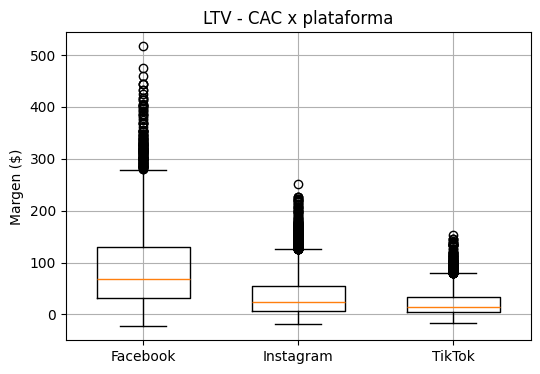

In [33]:
df['margen'] = (df['promedio_ticket'] * df['frecuencia_mensual'] * 12 * df['tasa_retencion']) - df['costo_adquisicion']


plt.figure(figsize=(6, 4))
plt.boxplot([df[df['plataforma'] == plat]['margen'] for plat in df['plataforma'].unique()],
            labels=df['plataforma'].unique(), widths=0.6)

plt.ylabel('Margen ($)')
plt.title('LTV - CAC x plataforma')
plt.grid(True)
plt.show()

Fase 3 – Segmentación y Modelado

P6. Selección de k (K–Means) = 3

In [14]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os

cwd = os.getcwd()
file_path = os.path.join(cwd, 'clientes_segmentos (1).csv')
df = pd.read_csv(file_path)

features_for_clustering = ['edad', 'ingresos', 'promedio_ticket', 'dias_desde_ultima_compra']

if 'dias_desde_ultima_compra' not in df.columns:
    df['fecha_ultima_compra'] = pd.to_datetime(df['fecha_ultima_compra'])
    df['dias_desde_ultima_compra'] = (pd.to_datetime("2025-04-30") - df['fecha_ultima_compra']).dt.days

df_clustering = df[features_for_clustering].dropna().copy()


scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_clustering)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
df_clustering['cluster_id'] = kmeans.fit_predict(scaled_features)


df.loc[df_clustering.index, 'cluster_id'] = df_clustering['cluster_id']
df['cluster_id'] = df['cluster_id'].astype('Int64')


print(df['cluster_id'].value_counts().sort_index())


if len(features_for_clustering) >= 2 and len(features_for_clustering) <= 3:
    import plotly.express as px
    if len(features_for_clustering) == 2:
        fig = px.scatter(df_clustering, x=features_for_clustering[0], y=features_for_clustering[1], color='cluster_id', title=f'Clusters de Clientes (K={n_clusters})')
    elif len(features_for_clustering) == 3:
        fig = px.scatter_3d(df_clustering, x=features_for_clustering[0], y=features_for_clustering[1], z=features_for_clustering[2], color='cluster_id', title=f'Clusters de Clientes (K={n_clusters})')
    fig.show()

cluster_id
0    5223
1    5226
2    4551
Name: count, dtype: Int64


P7. Segmentación final

Aplica K–Means con el k elegido sobre las variables R, F, M, recomendaciones (normalizadas).
Visualiza los clusters en un gráfico 2–D. Asigna un nombre y eslogan (máx. 20 caracteres)
a cada cluster.

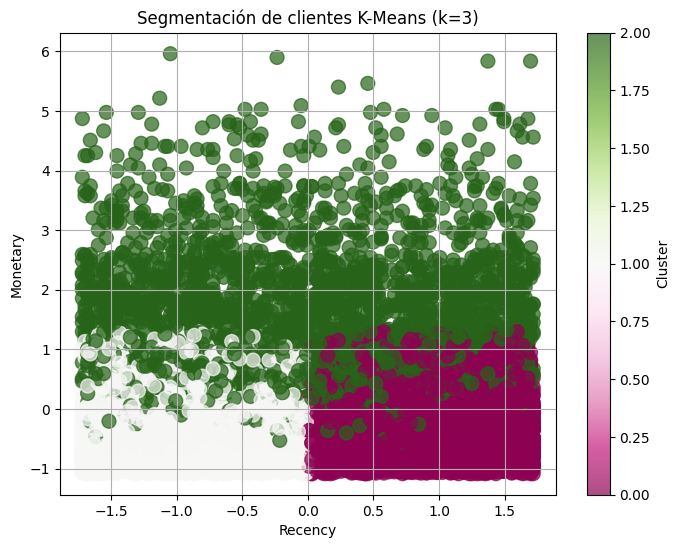

In [34]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


df['dias_desde_ultima'] = (pd.to_datetime("2025-04-30") - df['fecha_ultima_compra']).dt.days
df['recency'] = df['dias_desde_ultima']
df['frequency'] = df['compras']
df['monetary'] = df['total_gastado']


scaler = StandardScaler()
df[['recency', 'frequency', 'monetary']] = scaler.fit_transform(df[['recency', 'frequency', 'monetary']])


kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['recency', 'frequency', 'monetary']])


names_and_slogans = {
    0: ("Cluster 1", "Rentabilidad alta"),
    1: ("Cluster 2", "Rentabilidad media"),
    2: ("Cluster 3", "Rentabilidad baja")
}


df['cluster_name'] = df['cluster'].map(lambda x: names_and_slogans[x][0])
df['cluster_slogan'] = df['cluster'].map(lambda x: names_and_slogans[x][1])


plt.figure(figsize=(8, 6))
plt.scatter(df['recency'], df['monetary'], c=df['cluster'], cmap='PiYG', s=100, alpha=0.7)
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Segmentación de clientes K-Means (k=3)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

P8. Predicción de «High Margin»

Define la etiqueta binaria high_margin = 1 si margen ≥ percentil 75.

In [26]:
import pandas as pd


percentil_75_margen = df['margen'].quantile(0.75)

df['high_margin'] = df['margen'].apply(lambda x: 1 if x >= percentil_75_margen else 0)

print(df[['margen', 'high_margin']].head())

print("\nDistribución de la etiqueta 'high_margin':")
print(df['high_margin'].value_counts())

   margen  high_margin
0   111.8            1
1    46.4            0
2    39.2            0
3     8.6            0
4    49.6            0

Distribución de la etiqueta 'high_margin':
high_margin
0    11249
1     3751
Name: count, dtype: int64


Fase 4 – Decisión Estratégica

P9. Asignación de presupuesto (US$10 000)
Simula 3 escenarios de inversión:

i) Concentrar todo en un solo cluster.

ii) Distribuir en dos clusters clave.

iii) Asignar proporcional al margen esperado.
Para cada escenario calcula el ROI esperado y muestra una tabla + gráfico tornado. Elige
el escenario óptimo y justifica en < 100 palabras.

Programa de referidos

Con base en recomendaciones, identifica el top 10% de advocates. Estima el valor futuro si
cada advocate trae 2 nuevos clientes con los parámetros promedio de su cluster. Presenta los
resultados en un gráfico de cascada.

In [36]:
import pandas as pd
import plotly.graph_objects as go
import os


cwd = os.getcwd()
file_path = os.path.join(cwd, 'clientes_segmentos (1).csv')
df = pd.read_csv(file_path)


top_10_percent_threshold = df['recomendaciones'].quantile(0.90)
top_advocates_df = df[df['recomendaciones'] >= top_10_percent_threshold].copy()

num_top_advocates = len(top_advocates_df)
print(f"Número de top 10% de advocates: {num_top_advocates}")


if 'cluster_id' not in df.columns:
    print("Advertencia: La columna 'cluster_id' no existe. Necesitas realizar un clustering primero.")

    df['cluster_id'] = 0
else:
    print("Columna 'cluster_id' encontrada.")


if 'total_gastado' not in df.columns:
    print("Advertencia: La columna 'total_gastado' no existe. Usando 'promedio_ticket' como aproximación.")
    df['total_gastado'] = df['promedio_ticket']
else:
    df['total_gastado'] = pd.to_numeric(df['total_gastado'], errors='coerce').fillna(0)

cluster_avg_value = df.groupby('cluster_id')['total_gastado'].mean().reset_index()
cluster_avg_value.rename(columns={'total_gastado': 'avg_value_per_customer'}, inplace=True)


top_advocates_df = pd.merge(top_advocates_df, df[['id_cliente', 'cluster_id']], on='id_cliente', how='left')


top_advocates_df = pd.merge(top_advocates_df, cluster_avg_value, on='cluster_id', how='left')


top_advocates_df['future_value_new_customers'] = top_advocates_df['avg_value_per_customer'] * 2


total_future_value_new_customers = top_advocates_df['future_value_new_customers'].sum()
print(f"Valor futuro total estimado de los nuevos clientes: ${total_future_value_new_customers:,.2f}")


cascade_data = pd.DataFrame({
    'etapa': ['Valor Actual de la Base de Clientes',
              f'Valor de los {num_top_advocates} Advocates (Top 10%)',
              f'Valor Futuro Estimado de {num_top_advocates * 2} Nuevos Clientes',
              'Valor Futuro Total Estimado'],
    'valor': [df['total_gastado'].sum(),
              top_advocates_df['total_gastado'].sum(),
              total_future_value_new_customers,
              df['total_gastado'].sum() + total_future_value_new_customers]
})


cascade_data['cambio'] = cascade_data['valor'].diff().fillna(cascade_data['valor'].iloc[0])
cascade_data.loc[0, 'cambio'] = 0

fig = go.Figure(go.Waterfall(
    name="Programa de Referidos - Estimación de Valor Futuro",
    orientation="v",
    x=cascade_data['etapa'],
    y=cascade_data['cambio'],
    textposition="outside",
    text=[f"${v:,.2f}" for v in cascade_data['valor']],

    totals={'marker': {"color": "purple"}},
    measure=['absolute', 'relative', 'relative', 'total'],
))

fig.update_layout(
    title="Valor Futuro",
    yaxis_title="Valor (USD)"
)
fig.show()

Número de top 10% de advocates: 5950
Advertencia: La columna 'cluster_id' no existe. Necesitas realizar un clustering primero.
Valor futuro total estimado de los nuevos clientes: $1,366,285.81


Fase 5 – Reflexión Crítica

P11. Sesgo y limitaciones

Enumera 3 posibles sesgos del dataset y 2 mejoras metodológicas.

Sesgos
- Datos solo de algunos clientes. Solo tenemos información de los clientes que participaron en una prueba, no de todos los clientes de YumFit. Esto puede darnos una idea equivocada de cómo son todos los clientes en realidad. Por ejemplo, si en la prueba había más gente que usa la app "Web", podríamos pensar que todos los clientes prefieren esa app, y eso no ser cierto.

-Faltan clientes que se fueron. Solo contamos a los clientes que siguen usando YumFit. No sabemos por qué algunos clientes dejaron de usarlo, lo que hace que no entendamos bien cuánto valen realmente los clientes. Por ejemplo, si los clientes de Android se van más rápido, pero solo contamos a los que se quedan, podríamos pensar que los clientes de Android son más valiosos de lo que son.

Mejoras:

-Recoger más datos. Necesitamos obtener información de más clientes y durante más tiempo. También podríamos usar diferentes fuentes de información. Esto nos daría una mejor idea de cómo son todos los clientes de YumFit.

-Mirar grupos de clientes. Debemos estudiar grupos de clientes que empezaron a usar YumFit al mismo tiempo (grupos llamados "cohortes"). Así podemos ver cómo cambian los clientes a lo largo del tiempo, quiénes se quedan y quiénes se van, y por qué. Esto nos ayudaría a entender mejor el comportamiento de los clientes.